In [1]:
# Importation des librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy.random as rnd
from scipy.stats import norm
from scipy.stats import multivariate_normal
from sklearn.mixture import GaussianMixture
from sklearn.datasets import make_blobs
from skimage import io
from PIL import Image
from io import BytesIO
import requests
from skimage.util import view_as_windows

In [2]:
# Importation des données
star_data = pd.read_csv ('data_star.csv')

L'objectif est de prédire la classe de l'étoile à partir des autres informations du dataset. Il s'agit donc d'un problème de classification, et il peut donc être pertinent d'utiliser des mélanges gaussiens. Dans un premier temps, nous allons regarder combien de classes d'étoile différentes sont présentes dans le dataset, et faire un mélange gaussien avec un nombre de composante égale au nombre de classe. 

Nous disposons de la classe des étoiles dans le dataset, mais nous allons considérer que nous n'avons pas accès à cette information pour faire de la classification non supervisée. Nous pourrons cependant utiliser la classe de l'étoile "vérifiée" pour évaluer la pertinence de notre algorithme. 

In [3]:
star_data.columns

Index(['Temperature (K)', 'Luminosity (L/Lo)', 'Radius (R/Ro)',
       'Absolute magnitude (Mv)', 'Star type', 'Star category', 'Star color',
       'Spectral Class'],
      dtype='object')

In [4]:
# affichage des différentes classes d'étoile. 
print(star_data[['Star category']].value_counts())
print('-----')
print(star_data[['Star category']].nunique())

Star category
Brown Dwarf      40
Hypergiant       40
Main Sequence    40
Red Dwarf        40
Supergiant       40
White Dwarf      40
Name: count, dtype: int64
-----
Star category    6
dtype: int64


In [5]:
# On enleve la classe de l'étoile pour faire de l'apprentissage supervisée
star_data.replace({'Spectral Class':{'M':0, 'A':1, 'B':2, 'F':1, 'O':2, 'K':0, 'G':1 }}, inplace=True)
star_data_model = star_data.drop(columns = ['Star category'])
    #star_data_model = star_data_model.drop(columns = ['Spectral Class'])

# Encodage des données string en float afin de pouvoir utiliser des méthodes de mélanges gaussiens plus facilement
star_data_model['Star color'], _ = pd.factorize(star_data_model['Star color'])
star_data_model['Spectral Class'], _ = pd.factorize(star_data_model['Spectral Class'])


star_data_model = np.array(star_data_model)

/var/folders/vv/yd9tg_vd01b85m5mbpmc1v3r0000gn/T/ipykernel_7170/3774495443.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  star_data.replace({'Spectral Class':{'M':0, 'A':1, 'B':2, 'F':1, 'O':2, 'K':0, 'G':1 }}, inplace=True)


In [6]:
GMM_star = GaussianMixture(n_components = 6, covariance_type='full')
GMM_star.fit(star_data_model)

GaussianMixture(n_components=6)

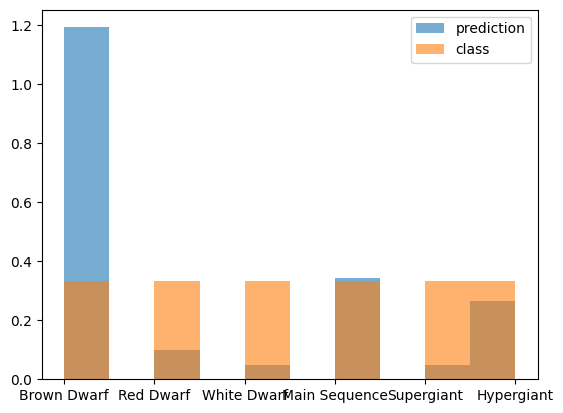

In [7]:
Y_pred = GMM_star.predict(star_data_model)
plt.hist(Y_pred, density = True, alpha = 0.6, label = 'prediction')
plt.hist(star_data['Star category'], density = True, alpha = 0.6, label = 'class')
plt.legend()
plt.show()

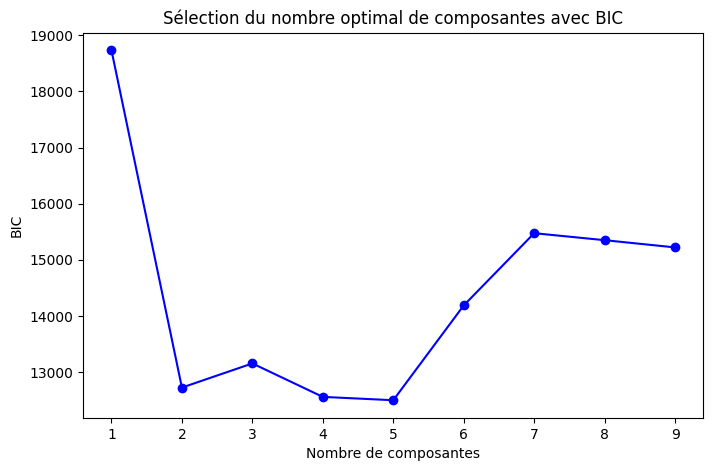

In [8]:
# On calcule le BIC pour voir si il n'est pas utile d'augmenter n_components (quite à rassembler les clusters après)
bic_scores = []
n_components_range = range(1, 10)

for g in n_components_range:
    gmm = GaussianMixture(n_components = g, covariance_type = 'full')
    gmm.fit(star_data_model)
    bic_scores.append(gmm.bic(star_data_model))  # Calcul du BIC

# Tracé du BIC en fonction du nombre de composantes
plt.figure(figsize = (8, 5))
plt.plot(n_components_range, bic_scores, marker = 'o', linestyle = '-', color = 'b')
plt.xlabel("Nombre de composantes")
plt.ylabel("BIC")
plt.title("Sélection du nombre optimal de composantes avec BIC")
plt.show()

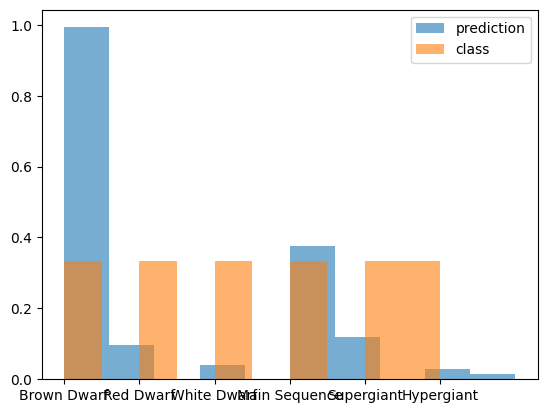

In [9]:
GMM_star_bic = GaussianMixture(n_components = 7, covariance_type='full')
GMM_star_bic.fit(star_data_model)

Y_pred_bic = GMM_star_bic.predict(star_data_model)
plt.hist(Y_pred_bic, density = True, alpha = 0.6, label = 'prediction')
plt.hist(star_data['Star category'], density = True, alpha = 0.6, label = 'class')
plt.legend()
plt.show()